<a href="https://colab.research.google.com/github/kevin7548/WCDL/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/WCDL')

Mounted at /content/drive


In [ ]:
!pip install cartopy xarray
!pip install tensorflow
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.3 MB/s eta 0:00:00


In [ ]:
import xarray as xr
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np
import seaborn as sns
from math import sqrt

import matplotlib.pyplot as plt
import scipy.interpolate as interp
import cartopy.crs as ccrs

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import load_model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, GRU
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Define time and coordinates
train_time = pd.date_range(start='1/1/1979', end='12/1/2014', freq='MS') #36년(432)
test_time = pd.date_range(start='1/1/2015', end='12/1/2023', freq='MS') #9년(108)
all_time = pd.date_range(start='1/1/1979', end='12/1/2023', freq='MS') #45년(540)

#lon = np.linspace(-180, 177.5, 144)
#lat = np.linspace(90.0, -90.0, 73)
lon = np.linspace(-180, 180, 241)
lat = np.linspace(-90, 90, 121)

In [ ]:
# Load Seoul's monthly temperature data
kmt = xr.open_dataset('korea_mean_temp.nc')['t2m'].sel(valid_time=train_time)
df_kmt = pd.DataFrame(index=range(len(kmt)))
df_kmt['kmt'] = kmt

# Defined Functions

## 1. Stepwise

In [ ]:
# 변수 선정을 위한 함수
def stepwise(var,dataset,y):
  selected_var = [] ## 선택된 변수들
  sl_enter = 0.1#0.05
  sl_remove = 0.1#0.05

  sv_per_step = [] ## 각 스텝별로 선택된 변수들
  adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
  steps = [] ## 스텝
  step = 0

  while len(var) > 0:
    remainder = list(set(var) - set(selected_var))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서
    ## 선형 모형을 적합한다.
    for col in remainder:
        X = dataset[selected_var+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]

    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
      selected_var.append(pval.idxmin())
      ## 선택된 변수들에대해서
      ## 어떤 변수를 제거할지 고른다.
      while len(selected_var) > 0:
          selected_X = dataset[selected_var]
          selected_X = sm.add_constant(selected_X)
          selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
          max_pval = selected_pval.max()
          if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
              remove_variable = selected_pval.idxmax()
              selected_var.remove(remove_variable)
          else:
              break
      step += 1
      steps.append(step)
      adj_r_squared = sm.OLS(y,sm.add_constant(dataset[selected_var])).fit().rsquared_adj
      adjusted_r_squared.append(adj_r_squared)
      sv_per_step.append(selected_var.copy())
    else:
      break

  fig = plt.figure(figsize=(7,7))
  fig.set_facecolor('white')

  col = (0., 70/255, 42/255)
  font_size = 8
  # plt.xticks(steps[:],[f'{s}\n' for s in steps]) #+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=8)
  plt.plot(steps[:],adjusted_r_squared[:], marker='o',markersize = 3, c=col,alpha=0.6)
  plt.ylabel('Adjusted R Squared',fontsize=font_size)
  plt.grid(True)
  plt.show()

  return sv_per_step

## 2. Heatmap

In [ ]:
def heatmap(data1):
  cm = np.corrcoef(data1.values.T)

  plt.figure(figsize = (15,8))
  sns.heatmap(cm, cbar=True, cmap='vlag', vmin=-1.0, vmax=1.0, annot=True, square=True, fmt='.2f', annot_kws={'size':10},
            yticklabels=data1.columns, xticklabels=data1.columns)
  plt.show()

  kc_vif = pd.DataFrame()
  kc_vif["VIF"] = [variance_inflation_factor(data1.values, i) for i in range(data1.shape[1])]
  kc_vif["features"] = data1.columns
  return kc_vif

## 3. Time lag

In [ ]:
# 시계열 데이터의 지연성을 고려하기 위한 함수
# 데이터 프레임을 shift하면서 하나의 행에 지난 시간의 데이터까지 모두 들어가도록 함
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()

	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

	agg = concat(cols, axis=1)
	agg.columns = names

	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Correlation

## 1. Load Data

In [ ]:
# Load nc data
f_clm = xr.open_dataset('new_clm.nc').sel(time=train_time)
f_idx = xr.open_dataset('clm_idx.nc').sel(time=train_time)

idx_vars = list(f_idx.data_vars)
upper_idx_vars = [var.upper() for var in idx_vars]
rename_dict = dict(zip(idx_vars, upper_idx_vars))
f_idx = f_idx.rename(rename_dict)

combined_df = pd.DataFrame(index=range(len(df_kmt)), columns=list(f_idx.data_vars)+list(f_clm.data_vars))

for f in [f_clm, f_idx]:
    vlist = list(f.data_vars)
    for v in f.data_vars:
        combined_df[v] = f[v].values

combined_df

,AAO,AMMSST,AMON.US.LONG,AO,EA,ESPI,GMSST,MEIV2,NAO,NINA1.ANOM,...,WP,mslp_uyg,mslp_sf,icec_arc,mtnlwr_sib,mtnlwr_ant,t2m_uyg,t2m_cl,snowc_cl,snowc_eura
0,0.209,1.15,-0.205,-2.233,-0.79,1.01533,0.09,0.47,-2.12,0.16,...,1.43,103301.0000,101233.0000,0.207520,-153.180176,-194.258301,267.032532,297.598938,0.001953,100.000000
1,0.356,2.50,-0.164,-0.697,-0.20,0.70502,-0.13,0.29,-1.20,-0.58,...,-0.66,102269.5625,101145.4375,0.246796,-163.896240,-186.048584,273.612061,295.151123,0.023438,100.000000
2,0.899,2.37,-0.241,-0.814,-0.10,0.17286,0.24,-0.05,0.41,-0.58,...,-0.29,101963.1875,101331.4375,0.215668,-183.544434,-171.356934,280.736389,292.818420,0.115234,100.000000
3,0.678,2.16,-0.250,-1.157,0.15,-0.15151,0.23,0.21,-2.01,0.15,...,0.85,101338.4375,101518.8125,0.595154,-203.935791,-160.974854,290.524902,288.476074,1.091797,78.550781
4,0.724,2.42,-0.130,-0.250,-0.83,-0.09556,-0.03,0.27,-0.90,-0.13,...,-0.13,100855.5625,102086.9375,0.626251,-210.410889,-150.391357,294.805359,287.430359,9.828125,5.052734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,-0.059,-0.34,0.313,-0.371,-1.69,0.14441,0.92,0.23,-2.28,0.89,...,-0.77,100443.1250,102038.2500,0.763763,-245.885742,-145.022461,302.124542,287.425323,99.664062,0.000000
428,-1.119,1.80,0.288,0.102,0.47,0.21027,1.11,-0.09,1.72,0.80,...,-1.23,101022.9375,101782.8125,0.652802,-218.021240,-156.732178,295.792419,289.792419,48.443359,1.738281
429,-0.039,3.18,0.270,-1.134,-0.37,0.55725,1.02,0.12,-0.87,0.69,...,-0.32,101924.8750,101412.8750,0.682495,-193.503418,-173.331543,287.011963,295.142822,6.998047,18.443359
430,-0.519,3.10,0.043,-0.530,1.28,0.15872,0.86,0.37,0.58,0.80,...,0.13,102641.5000,101410.6250,0.220337,-173.092285,-187.502441,274.240112,295.324097,1.816406,34.292969


In [ ]:
#vlist = np.hstack([list(f_clm.data_vars), list(f_idx.data_vars)])
vlist = list(f_clm.data_vars) + list(f_idx.data_vars)
corr = np.zeros([len(vlist), 6])

#for i, v in enumerate(vlist):
#    corr[i,:] = np.array([np.corrcoef(combined_df[v].values[11+x::12][:df_kmt[12::12].shape[0]], df_kmt[12::12].T)[0][1] for x in range(0,-6,-1)])

for i, v in enumerate(vlist):
    corr[i,:] = np.array([np.corrcoef(combined_df[v].values[12+x::12][:df_kmt[17::12].shape[0]], df_kmt[17::12].T)[0][1] for x in range(4,-2,-1)])

In [ ]:
vals = pd.DataFrame(np.full([len(vlist), 6], np.nan))
maxcorr = []

for i in range(len(vlist)):
    ind = None; value=0
    for j in range(6):
        if np.abs(corr[i,j]) > value:
            ind = j
            value=np.abs(corr[i,j])
    vals.iloc[i,ind] = str(np.round(corr[i,ind], 2))
    maxcorr.append(ind)

vals = vals.replace(np.nan, '').values
vals

array([['', '0.23', '', '', '', ''],
       ['', '0.46', '', '', '', ''],
       ['', '', '', '-0.53', '', ''],
       ['', '', '', '0.48', '', ''],
       ['', '0.32', '', '', '', ''],
       ['', '', '0.38', '', '', ''],
       ['', '', '', '', '0.39', ''],
       ['', '', '', '', '0.17', ''],
       ['', '', '', '', '', '-0.09'],
       ['', '0.17', '', '', '', ''],
       ['', '', '', '0.4', '', ''],
       ['', '', '', '', '', '0.52'],
       ['', '', '', '-0.34', '', ''],
       ['', '', '', '', '-0.29', ''],
       ['-0.28', '', '', '', '', ''],
       ['0.58', '', '', '', '', ''],
       ['-0.33', '', '', '', '', ''],
       ['', '', '-0.29', '', '', ''],
       ['', '', '', '-0.27', '', ''],
       ['-0.28', '', '', '', '', ''],
       ['', '', '', '', '0.08', ''],
       ['-0.21', '', '', '', '', ''],
       ['-0.26', '', '', '', '', ''],
       ['', '', '', '', '0.67', ''],
       ['-0.3', '', '', '', '', ''],
       ['-0.25', '', '', '', '', ''],
       ['', '', '', '', '',

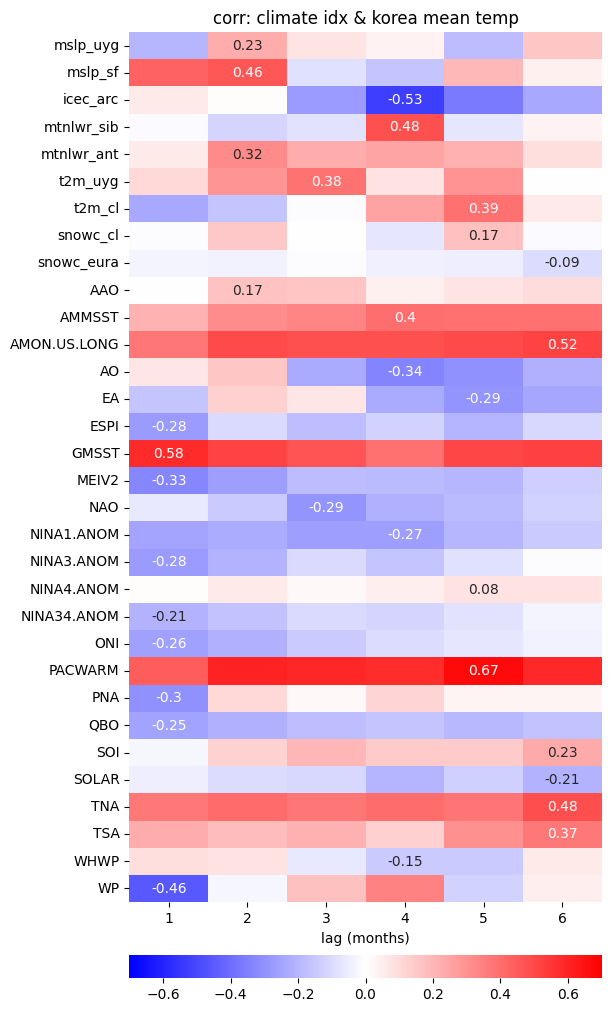

In [ ]:
fig = plt.figure(figsize=(6,10), constrained_layout=True, facecolor='w')

plot = sns.heatmap(corr, cmap=plt.get_cmap('bwr'), vmin=-0.7, vmax=0.7, annot=vals, fmt='',
                   cbar_kws = dict(use_gridspec=False,location='bottom',pad=0.01))

plt.yticks(np.arange(0.5, len(vlist)+0.5, 1), labels=vlist, rotation=0)
plt.xlabel('lag (months)')
plt.xticks(np.arange(0.5,6.5,1), labels=np.arange(1,7))
plt.title('corr: climate idx & korea mean temp')
plt.show()

# Stepwise

In [ ]:
max(maxcorr)

5

In [ ]:
clmidx = pd.concat([df_kmt, combined_df], axis=1)
for var, lag in zip(vlist, maxcorr):
  clmidx[var] = clmidx[var].shift(lag+1)

clmidx = clmidx.dropna(axis=0)
clmidx

,kmt,AAO,AMMSST,AMON.US.LONG,AO,EA,ESPI,GMSST,MEIV2,NAO,...,WP,mslp_uyg,mslp_sf,icec_arc,mtnlwr_sib,mtnlwr_ant,t2m_uyg,t2m_cl,snowc_cl,snowc_eura
6,295.060516,0.724,2.37,-0.205,-0.814,-0.20,-1.12730,0.18,-0.11,-2.01,...,1.56,100855.5625,102086.9375,0.215668,-183.544434,-150.391357,290.524902,295.151123,0.023438,100.000000
7,296.712433,1.700,2.16,-0.164,-1.157,-0.10,-0.87678,0.02,-0.11,-0.90,...,1.72,100530.0000,102543.3750,0.595154,-203.935791,-146.576416,294.805359,292.818420,0.115234,100.000000
8,292.233582,2.412,2.42,-0.241,-0.250,0.15,0.65850,0.13,0.47,1.92,...,1.57,100389.2500,102453.7500,0.626251,-210.410889,-138.198486,300.908936,288.476074,1.091797,100.000000
9,287.965790,0.546,1.96,-0.250,0.933,-0.83,-0.36576,0.26,0.38,0.86,...,0.35,100424.0625,101829.4375,0.834259,-228.775635,-146.180420,300.946655,287.430359,9.828125,78.550781
10,279.439575,0.629,1.16,-0.130,0.038,0.78,-0.02439,0.26,0.23,1.11,...,0.71,101286.5625,101760.6875,0.895782,-230.639893,-150.797363,300.257141,282.799561,71.238281,5.052734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,296.198395,0.841,-3.68,-0.064,0.972,-0.11,0.11128,0.75,0.42,-0.80,...,-1.63,100483.2500,102280.2500,0.846924,-203.222656,-145.426025,295.775818,292.156311,0.707031,99.496094
428,293.100922,0.247,-3.80,-0.103,0.464,1.23,0.14441,0.92,0.23,-0.67,...,-0.77,100110.6250,102433.6250,0.751251,-220.977783,-143.100098,299.464752,289.498779,2.693359,62.818359
429,287.876556,-0.059,-4.29,-0.116,-0.507,-1.45,0.21027,1.11,-0.09,0.21,...,-1.23,100443.1250,102038.2500,0.816650,-235.156494,-145.022461,303.400940,286.832458,23.822266,25.199219
430,281.830841,-1.119,-2.13,-0.023,-0.489,0.03,0.55725,1.02,0.12,-2.28,...,-0.32,101022.9375,101782.8125,0.803223,-231.186035,-156.732178,302.124542,283.572174,93.554688,2.724609


In [ ]:
# JJA 일때의 행만 걸러주기
month = [7,8,9,10,11,12]
month.extend(list(np.arange(1,13))*35)
clmidx['month'] = month
clmidx = clmidx[clmidx['month']==6]
freq12_JJA = clmidx.drop(['month'], axis=1)

freq12_JJA

,kmt,AAO,AMMSST,AMON.US.LONG,AO,EA,ESPI,GMSST,MEIV2,NAO,...,WP,mslp_uyg,mslp_sf,icec_arc,mtnlwr_sib,mtnlwr_ant,t2m_uyg,t2m_cl,snowc_cl,snowc_eura
17,292.227875,-2.068,3.35,-0.072,-0.934,0.31,0.75912,0.45,0.45,-0.73,...,1.85,101319.3750,101704.6250,0.372528,-167.862061,-163.623779,280.589478,297.886597,0.099609,100.000000
29,291.316711,-1.462,2.78,-0.261,-0.332,0.11,-0.68481,0.32,-0.24,-1.65,...,0.16,101194.0625,101696.6875,0.368347,-169.515869,-160.731201,283.574890,296.344330,0.048828,100.000000
41,291.829498,1.531,-0.22,-0.014,0.974,0.30,-0.04837,0.26,-0.12,0.80,...,0.67,101491.5000,101639.2500,0.000000,-169.302246,-156.509277,282.731812,298.297913,0.005859,100.000000
53,291.323212,0.149,-3.18,-0.388,-1.806,1.31,1.53672,0.43,2.86,0.59,...,0.50,101217.6875,101577.0625,0.332825,-163.735107,-159.417480,281.500671,296.797424,0.017578,96.814453
65,292.492462,-0.204,-2.97,-0.011,-0.303,-2.06,-1.61688,0.46,-0.45,-0.79,...,-1.73,101211.6875,101776.4375,0.146393,-164.341309,-155.842529,282.447876,296.986420,0.367188,70.927734
77,291.749573,0.031,-2.71,-0.326,-1.440,-0.34,-1.27089,0.11,-1.23,-0.19,...,0.72,101052.0625,101589.4375,0.249512,-170.334229,-158.740479,279.918335,296.012329,0.033203,100.000000
89,291.627991,-0.087,-4.40,-0.345,-2.904,-1.11,0.21204,0.28,-0.26,1.39,...,0.28,101536.3750,101542.1250,0.325867,-168.449707,-159.354248,280.029175,298.372803,0.054688,100.000000
101,292.021637,-0.286,-2.74,-0.380,-1.473,0.82,2.14975,0.25,1.96,-0.26,...,1.77,101086.4375,101620.1875,0.079651,-164.101318,-155.795410,282.773865,298.027283,0.052734,100.000000
113,292.413605,-0.077,-2.51,0.034,-1.066,-1.09,-0.81966,0.60,-0.39,-0.58,...,-0.15,101591.8750,101686.8750,0.146484,-163.972656,-162.081787,279.346008,297.796143,0.095703,100.000000
125,291.140564,-0.573,-2.84,-0.177,3.279,1.14,-0.72076,0.18,-1.03,1.54,...,0.36,101195.8125,101792.4375,0.255585,-168.634277,-159.030029,280.503540,298.951111,0.144531,97.007812


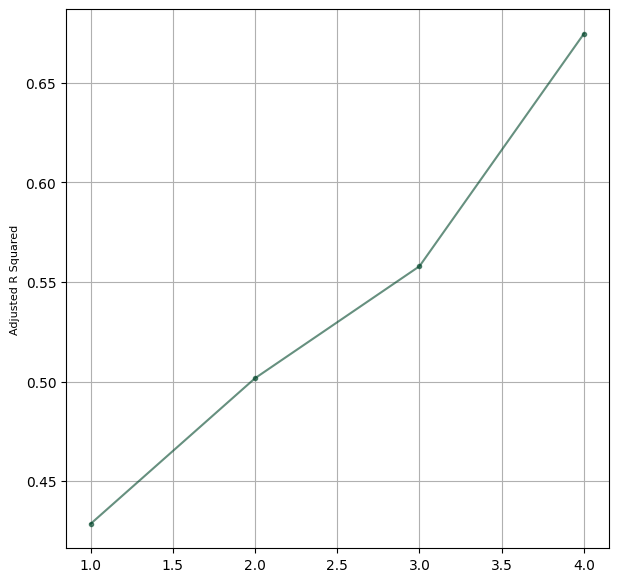

In [ ]:
# stepwise 구현
freq_x = freq12_JJA.drop(['kmt'], axis=1).copy()
freq_var = freq_x.columns
freq_step = stepwise(freq_var, freq_x, freq12_JJA['kmt'])

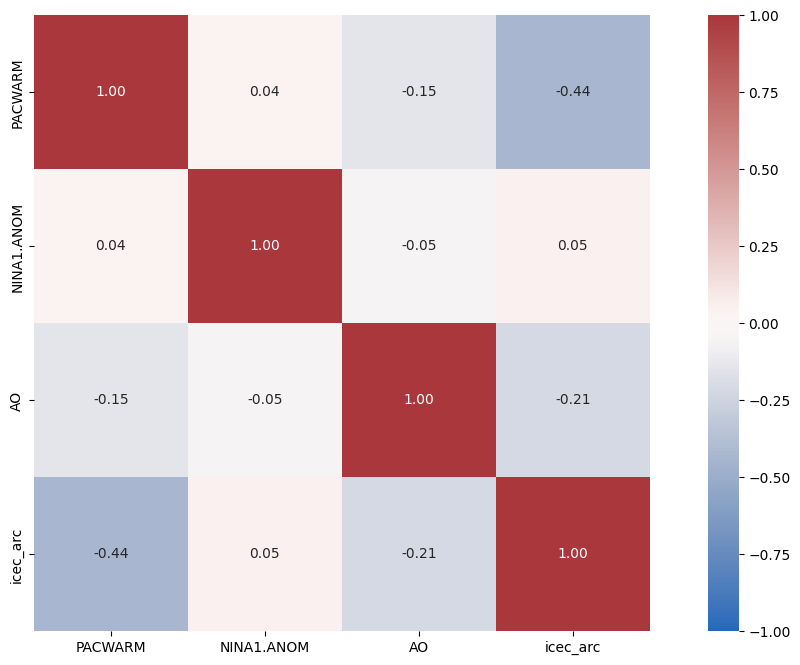

,VIF,features
0,1.921812,PACWARM
1,1.014041,NINA1.ANOM
2,1.142175,AO
3,1.996302,icec_arc


In [ ]:
kc_newh = freq_x[freq_step[-1]]
heatmap(kc_newh)

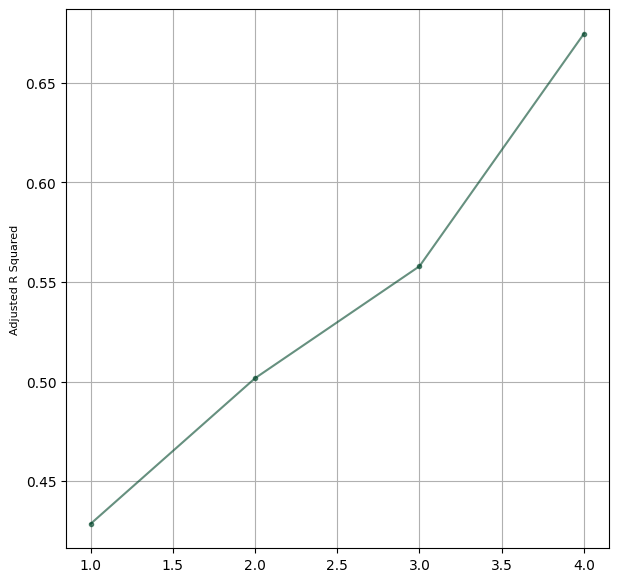

In [ ]:
# stepwise 구현
## NINA1.ANOM
test = freq12_JJA.drop(['kmt', 'WP'], axis=1).copy()
test_var = test.columns
test_step = stepwise(test_var, test, freq12_JJA['kmt'])

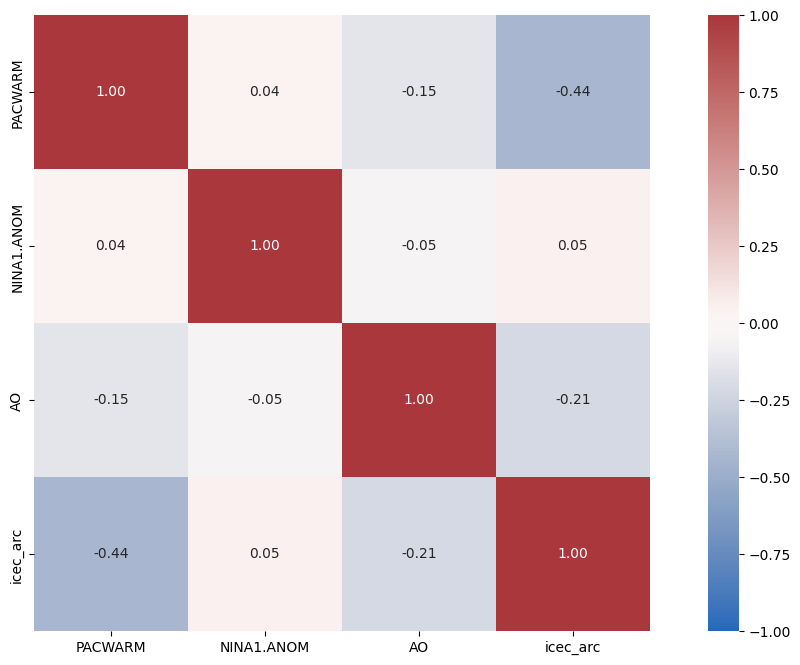

,VIF,features
0,1.921812,PACWARM
1,1.014041,NINA1.ANOM
2,1.142175,AO
3,1.996302,icec_arc


In [ ]:
heatmap(test[test_step[-1]])

# MODEL

## 1. preprocessing

In [ ]:
f = xr.open_dataset('korea_mean_temp.nc')['t2m']
df = pd.DataFrame(index=range(len(f)))
df['kmt'] = f

f1 = xr.open_dataset('clm_idx.nc')
indices1 = ['pacwarm', 'nina1.anom', 'ao']

tmp1 = pd.DataFrame(index=range(len(f)))
for var in indices1:
  tmp1[var] = f1[var].values
tmp1.columns = [col.upper() for col in tmp1.columns]

f2 = xr.open_dataset('new_clm.nc')
indices2 = ['icec_arc']

tmp2 = pd.DataFrame(index=range(len(f)))
for var in indices2:
  tmp2[var] = f2[var].values

KMT_Data = pd.concat([df, tmp1, tmp2], axis=1)
KMT_Data

,kmt,PACWARM,NINA1.ANOM,AO,icec_arc
0,273.157806,-0.271,0.16,-2.233,0.207520
1,273.655304,-0.186,-0.58,-0.697,0.246796
2,277.516388,-0.188,-0.58,-0.814,0.215668
3,281.732300,-0.284,0.15,-1.157,0.595154
4,287.239014,-0.380,-0.13,-0.250,0.626251
...,...,...,...,...,...
535,298.353729,0.300,3.29,-0.602,0.849731
536,295.263733,0.210,2.42,0.318,0.636108
537,288.674561,0.212,2.32,-0.414,0.633850
538,280.433716,0.267,2.07,-0.036,0.359344


In [ ]:
# 시간 지연을 고려하여 1개월전부터 12개월전까지의 모든 값들을 넣어줌
n_features = len(KMT_Data.columns)
n_months = 12
ref_kmt = series_to_supervised(KMT_Data, n_months, 1)
endcolumn = (n_features)*(n_months+1)
ref_kmt.drop(ref_kmt.columns[list(np.arange((endcolumn-(n_features-1)), endcolumn))], axis=1, inplace=True)

In [ ]:
# dataframe normalization
values = ref_kmt.values.astype('float32')
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

new_kmt = pd.DataFrame(scaled, columns=ref_kmt.columns, index=ref_kmt.index)
new_kmt

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var1(t-11),var2(t-11),var3(t-11),var4(t-11),var5(t-11),...,var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
12,-0.677591,-0.462279,-0.348983,-0.476098,-0.560113,-0.644566,-0.325843,-0.580595,-0.080273,-0.476857,...,-0.555377,-0.355243,0.221750,0.555843,-0.522882,-0.443018,-0.424100,0.433063,-0.251609,-0.874542
13,-0.644566,-0.325843,-0.580595,-0.080273,-0.476857,-0.388247,-0.329053,-0.580595,-0.110424,-0.542840,...,-0.443018,-0.424100,0.433063,-0.251609,-0.874542,-0.473515,-0.477308,-0.433063,-0.114921,-0.816967
14,-0.388247,-0.329053,-0.580595,-0.110424,-0.542840,-0.108374,-0.483146,-0.352113,-0.198815,0.261571,...,-0.473515,-0.477308,-0.433063,-0.114921,-0.816967,-0.640449,-0.530516,-0.141348,-0.210337,-0.421778
15,-0.108374,-0.483146,-0.352113,-0.198815,0.261571,0.257189,-0.637239,-0.439750,0.034918,0.327490,...,-0.640449,-0.530516,-0.141348,-0.210337,-0.421778,-0.463884,-0.402191,-0.269939,0.081800,-0.130556
16,0.257189,-0.637239,-0.439750,0.034918,0.327490,0.590944,-0.589085,-0.348983,0.339776,0.768412,...,-0.463884,-0.402191,-0.269939,0.081800,-0.130556,-0.590690,-0.399061,-0.008633,0.128699,0.291513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,0.929525,0.343499,-0.586854,0.055534,0.647249,0.680384,0.545746,-0.718310,-0.069450,0.878255,...,0.367576,0.383412,0.025641,0.683863,0.935154,0.455859,0.533646,0.059657,0.762396,0.995041
536,0.680384,0.545746,-0.718310,-0.069450,0.878255,0.234058,0.430176,-0.956182,0.446205,0.602355,...,0.455859,0.533646,0.059657,0.762396,0.995041,0.454254,0.630673,-0.055792,0.801210,0.789911
537,0.234058,0.430176,-0.956182,0.446205,0.602355,-0.049730,0.340289,-0.752739,0.186703,0.283436,...,0.454254,0.630673,-0.055792,0.801210,0.789911,0.309791,0.358373,0.181291,0.348384,0.352488
538,-0.049730,0.340289,-0.752739,0.186703,0.283436,-0.746538,0.263242,-0.543036,-0.601340,-0.974254,...,0.309791,0.358373,0.181291,0.348384,0.352488,0.313002,0.327074,-0.007344,0.343597,-0.194580


## 2. Modeling

In [ ]:
additional_layer = True
n_neurons = 60
n_batch_size = 32
combination_no = 9
dropout = 0.2

In [ ]:
# 학습 데이터, 테스트 데이터 분리
values = new_kmt.values
n_train_hours = 12 * (int(len(train_time)/12) -1)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(420, 1, 60) (420,) (108, 1, 60) (108,)


In [ ]:
model = Sequential()
model.add(GRU(units=n_neurons, return_sequences=True, input_shape=(1, train_X.shape[1])))
model.add(Dropout(dropout))
if additional_layer:
  model.add(GRU(units=n_neurons, return_sequences=True))
  model.add(Dropout(dropout))
model.add(GRU(units=n_neurons, return_sequences=True))
model.add(Dropout(dropout))
model.add(GRU(units=n_neurons, return_sequences=True))
model.add(Dropout(dropout))
model.add(GRU(units=n_neurons, return_sequences=True))
model.add(Dropout(dropout))
model.add(Dense(units=1, activation='relu'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/50


ValueError: Exception encountered when calling GRUCell.call().

[1mDimensions must be equal, but are 60 and 1 for '{{node sequential_1/gru_1/gru_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1/gru_1/strided_slice_2, sequential_1/gru_1/gru_cell_1/Cast/ReadVariableOp)' with input shapes: [?,60], [1,180].[0m

Arguments received by GRUCell.call():
  • inputs=tf.Tensor(shape=(None, 60), dtype=float32)
  • states=('tf.Tensor(shape=(None, 60), dtype=float32)',)
  • training=True

In [ ]:
### Test Data
# Prediction
yhat_test = model.predict(test_X)
test_X2 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# Transforming into before scale
inv_yhat_test = np.concatenate((yhat_test, test_X2), axis=1)
inv_yhat_test = scaler.inverse_transform(inv_yhat_test)[:,0]
# Processing actual value
test_y2 = test_y.reshape((len(test_y), 1))
inv_y_test = np.concatenate((test_y2, test_X2), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)[:,0]
# RMSE
rmse = sqrt(mean_squared_error(inv_y_test, inv_yhat_test))
print('Test RMSE: %.3f' %rmse)

### Train Data
# Prediction
yhat_train = model.predict(train_X)
train_X2 = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# Transforming into before scale
inv_yhat_train = np.concatenate((yhat_train, train_X2), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)[:,0]
# Processing actual value
train_y2 = train_y.reshape((len(train_y), 1))
inv_y_train = np.concatenate((train_y, train_X2), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)[:,0]
# RMSE
rmse = sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
print('Train RMSE: %.3f' % rmse)